In [22]:
!pip install keras-tuner

In [23]:
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np


In [24]:
tf.__version__

'2.13.0'

In [25]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.fashion_mnist.load_data()

In [26]:
x_train.shape

(60000, 28, 28)

In [27]:
x_test.shape

(10000, 28, 28)

In [28]:
set(y_train)   # 10 classes of data

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

y_train representing the classes of each training sample. set obtain the unique labels or classes present in the training set.

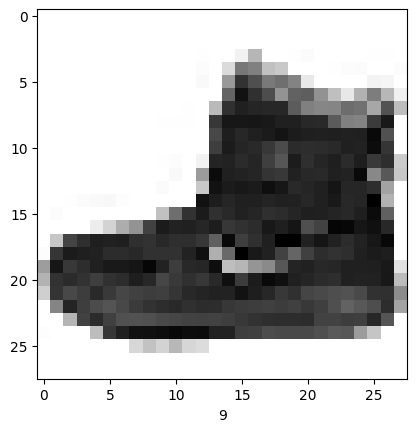

In [29]:
plt.imshow(x_train[0], cmap='binary')
plt.xlabel(y_train[0])
plt.show()

In [30]:
def create_model(hp):   # hp is hyperperameter object, which our tuner need,

  num_hidden_layers=1
  num_units=8   # hyperparameter
  dropout_rate=0.1  # parameter
  learning_rate= 0.01   # another parameter that we want to tune

  if hp:
    num_hidden_layers=hp.Choice('num_hidden_layers', values=[1,2,3])
    num_units=hp.Choice('num_units', values=[8,16,32])
    dropout_rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5)
    learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01)

  model=tf.keras.models.Sequential()

  model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
  model.add(tf.keras.layers.Lambda(lambda x: x/255.))

  for _ in range(0, num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_units, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))

  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy']

  )

  return model

In [31]:
create_model(None).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 lambda_1 (Lambda)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 6280      
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 10)                90        
                                                                 
Total params: 6370 (24.88 KB)
Trainable params: 6370 (24.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
class CustomTuner(kt.tuners.BayesianOptimization): # to find optimal batch size
  def run_trail(self, trial, *args, **kwargs):
    kwargs['batch_size']= trial.hyperparaneteres.Int('batch_size', 32, 128, step=32)
    super(CustomTuner, self.run_trial(trial, *args, **kwargs))


In [33]:
tuner=CustomTuner(
    create_model,
    objective='val_accuracy',
    max_trials=20,
    directory='logs',
    project_name='fashion_mnist',
    overwrite=True
)

In [34]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}


In [35]:
tuner.search(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5, verbose=True
)

Trial 20 Complete [00h 00m 33s]
val_accuracy: 0.8409000039100647

Best val_accuracy So Far: 0.8551999926567078
Total elapsed time: 00h 14m 08s


In [36]:
tuner.results_summary(1)

Results summary
Results in logs/fashion_mnist
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 12 summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
dropout_rate: 0.2544290660789602
learning_rate: 0.001730397832827377
Score: 0.8551999926567078


In [37]:
model = tuner.get_best_models(num_models=1)[0]

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 25450 (99.41 KB)
Trainable params: 25450 (99.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20, verbose=2,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
)

Epoch 1/20
469/469 - 2s - loss: 0.3999 - accuracy: 0.8540 - val_loss: 0.3888 - val_accuracy: 0.8603 - 2s/epoch - 5ms/step
Epoch 2/20
469/469 - 1s - loss: 0.3983 - accuracy: 0.8548 - val_loss: 0.3913 - val_accuracy: 0.8584 - 1s/epoch - 3ms/step
Epoch 3/20
469/469 - 2s - loss: 0.3954 - accuracy: 0.8551 - val_loss: 0.3892 - val_accuracy: 0.8595 - 2s/epoch - 3ms/step
Epoch 4/20
469/469 - 2s - loss: 0.3903 - accuracy: 0.8579 - val_loss: 0.3834 - val_accuracy: 0.8623 - 2s/epoch - 4ms/step
Epoch 5/20
469/469 - 1s - loss: 0.3916 - accuracy: 0.8571 - val_loss: 0.3847 - val_accuracy: 0.8637 - 1s/epoch - 3ms/step
Epoch 6/20
469/469 - 1s - loss: 0.3856 - accuracy: 0.8594 - val_loss: 0.3840 - val_accuracy: 0.8640 - 1s/epoch - 3ms/step
Epoch 7/20
469/469 - 1s - loss: 0.3831 - accuracy: 0.8593 - val_loss: 0.3850 - val_accuracy: 0.8611 - 1s/epoch - 3ms/step
Epoch 8/20
469/469 - 1s - loss: 0.3797 - accuracy: 0.8601 - val_loss: 0.3958 - val_accuracy: 0.8607 - 1s/epoch - 3ms/step
Epoch 9/20
469/469 - 1s 

In [39]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3834 - accuracy: 0.8615


[0.3833782374858856, 0.8615000247955322]